In [ ]:
import pandas as pd
df = pd.read_csv('Atlanta-airport-temperature.csv')
print(df.head())


       STATION                                               NAME        DATE  \
0  USW00013874  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  2000-01-01   
1  USW00013874  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  2000-01-02   
2  USW00013874  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  2000-01-03   
3  USW00013874  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  2000-01-04   
4  USW00013874  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  2000-01-05   

   TAVG  TMAX  TMIN  
0  58.0    66    49  
1  60.0    68    52  
2  65.0    73    57  
3  52.0    64    40  
4  41.0    48    33  


In [ ]:
cropped_df = df.iloc[:180]

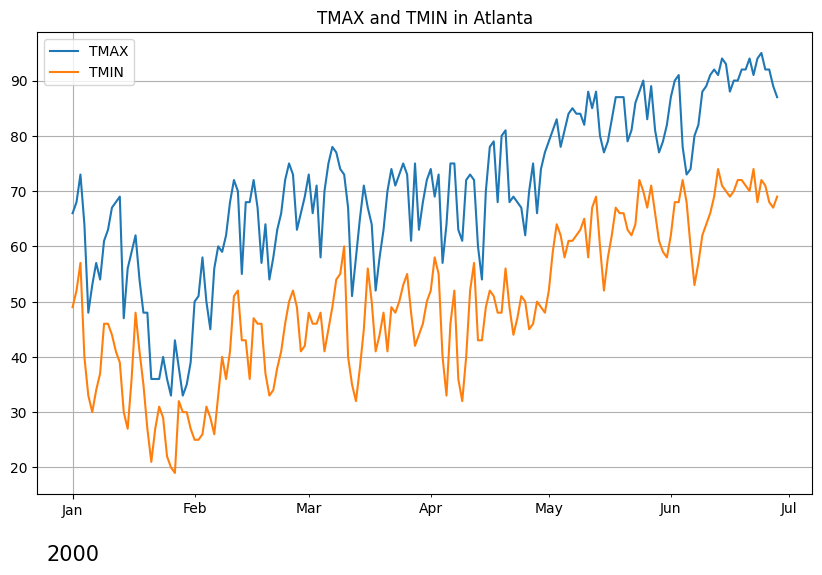

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# Assuming 'df' is already defined from the previous code
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plt.figure(figsize=(10, 6))
plt.plot(cropped_df['DATE'], cropped_df['TMAX'], label='TMAX')
plt.plot(cropped_df['DATE'], cropped_df['TMIN'], label='TMIN')
# plt.ylabel('Temperature')
plt.title('TMAX and TMIN in Atlanta')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
# Minor ticks every year.
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' to get the names of the month
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# fontsize for month labels
ax.tick_params(labelsize=10, which='both')
# create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

plt.show()

<ipython-input-37-da46691859f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df['DATE'] = pd.to_datetime(cropped_df['DATE'])
<ipython-input-37-da46691859f3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df['TMAX_pred'] = slope_tmax * cropped_df.index + intercept_tmax
<ipython-input-37-da46691859f3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

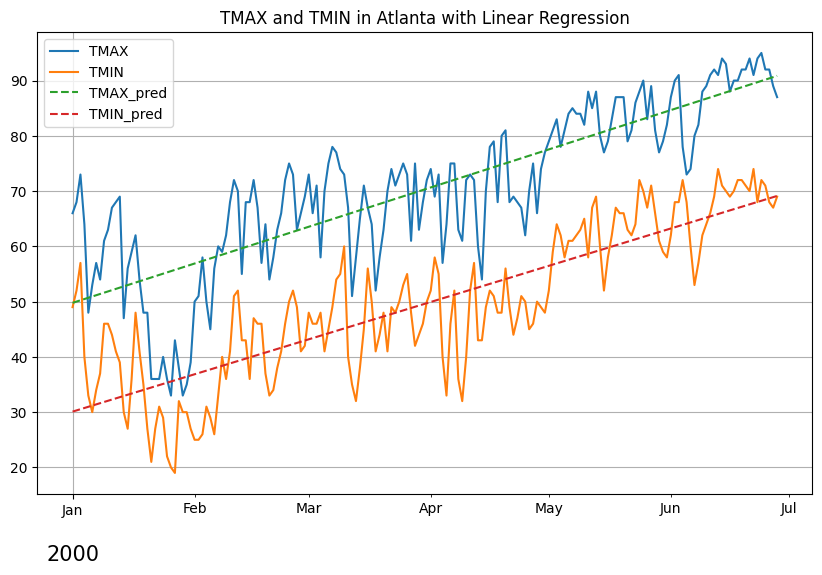

In [ ]:
from scipy.stats import linregress

# Assuming 'cropped_df' is already defined and 'DATE' column is datetime
cropped_df['DATE'] = pd.to_datetime(cropped_df['DATE'])

# Fit linear regression for TMAX
slope_tmax, intercept_tmax, r_value_tmax, p_value_tmax, std_err_tmax = linregress(
    cropped_df.index, cropped_df['TMAX']
)
cropped_df['TMAX_pred'] = slope_tmax * cropped_df.index + intercept_tmax

# Fit linear regression for TMIN
slope_tmin, intercept_tmin, r_value_tmin, p_value_tmin, std_err_tmin = linregress(
    cropped_df.index, cropped_df['TMIN']
)
cropped_df['TMIN_pred'] = slope_tmin * cropped_df.index + intercept_tmin

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(cropped_df['DATE'], cropped_df['TMAX'], label='TMAX')
plt.plot(cropped_df['DATE'], cropped_df['TMIN'], label='TMIN')
plt.plot(cropped_df['DATE'], cropped_df['TMAX_pred'], label='TMAX_pred', linestyle='--')
plt.plot(cropped_df['DATE'], cropped_df['TMIN_pred'], label='TMIN_pred', linestyle='--')

plt.title('TMAX and TMIN in Atlanta with Linear Regression')
plt.legend()
plt.grid(True)

# Formatting x-axis (same as before)
fmt_month = mdates.MonthLocator()
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.tick_params(labelsize=10, which='both')

sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

plt.show()

In [ ]:
import pymc as pm
# import theano
# import arviz

print('pymc version is ' + str(pm.__version__))
# print('theano version is ' + str(theano.__version__))
# print('arviz version is ' + str(arviz.__version__))

pymc version is 5.19.1


In [ ]:
xdata = np.arange(0, len(cropped_df['DATE']))
xdata = pd.DataFrame(xdata, columns=['DATE'])
ydata = cropped_df['TMAX']

In [ ]:
import numpy as np

with pm.Model() as linear_all_data:
    # prior distributions, Naive - set to Gaussian with very large variance
    intercept = pm.Normal('Intercept', mu = 0, sigma = 10.0) # model B0 - Intercept Prior
    slope = pm.Normal('slope', mu = 0, sigma = 10.0)         # model B1 - Slope Prior
    sigma = pm.HalfNormal('sigma', sigma = 10.0)             # homoscedastic error in standard deviation

    # specify the model, linear regression
    mean = intercept + slope * xdata                   # estimate of model

    # define the distribution of the predictions from the model and provide the sampled response features
    Y_obs = pm.Normal('Y_obs', mu = mean, sigma = sigma, observed = ydata) # Observed values

    # specify the sampler
    step = pm.NUTS(target_accept = 0.95) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC, adaptive step size

    # Posterior distribution
    #linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, return_inferencedata = True)
    linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = 0,
                                      discard_tuned_samples = False,return_inferencedata=True)

Output()

Output()

In [ ]:
import pandas as pd

In [ ]:
def trace_mean(x):
    return pd.Series(np.average(x, 0), name='mean')

def trace_sd(x):
    return pd.Series(np.std(x, 0), name='sd')

def trace_975(x):
    return pd.Series(np.percentile(x, 97.5), name='97.5')

def trace_025(x):
    return pd.Series(np.percentile(x, 2.5), name='2.5')

# Get the expectation / average for the model parameters from sampling the posterior distribution
bayes_exp_intercept = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[0,0]
bayes_exp_slope = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[-1,0]

pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean, trace_sd, trace_025, trace_975])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,trace_mean,trace_sd,trace_025,trace_975
Intercept,49.083,1.226,46.621,51.101,0.059,0.042,425.0,520.0,1.00,49.083,1.226,46.639,51.362
sigma,8.554,0.463,7.848,9.537,0.023,0.016,429.0,430.0,1.00,8.554,0.463,7.750,9.527
slope,0.235,0.012,0.215,0.260,0.001,0.000,475.0,640.0,1.01,0.235,0.012,0.212,0.260


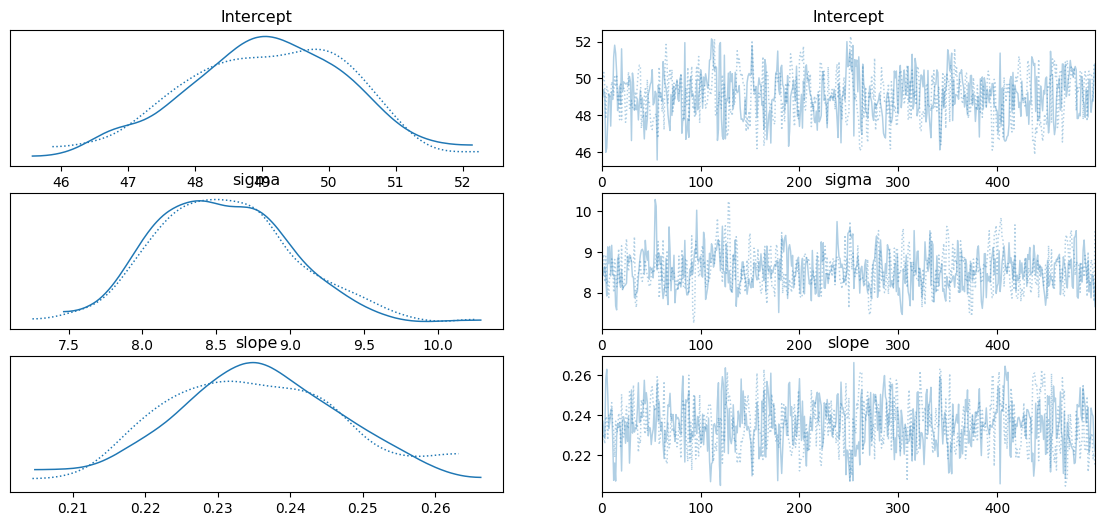

In [ ]:
with linear_all_data:
    pm.plot_trace(linear_trace_all_data, figsize = (14,6))

# plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

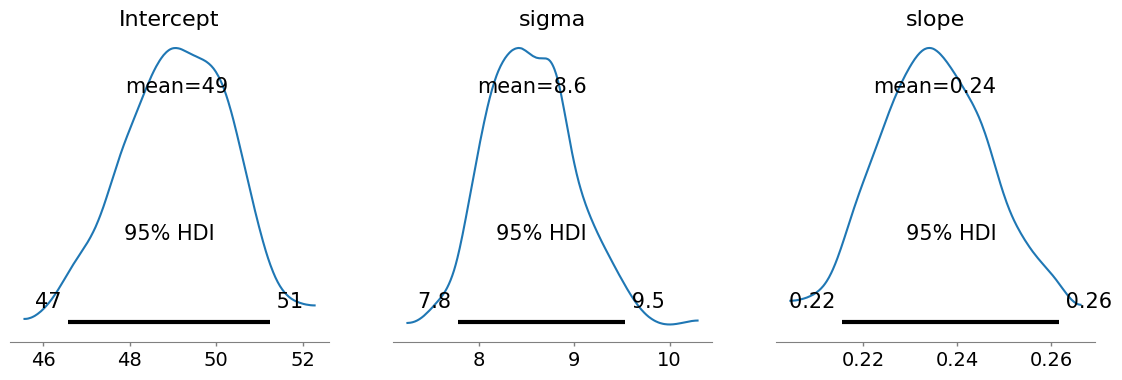

In [ ]:
with linear_all_data:
    pm.plot_posterior(linear_trace_all_data, hdi_prob = 0.95, figsize = (14,4))
plt.show()

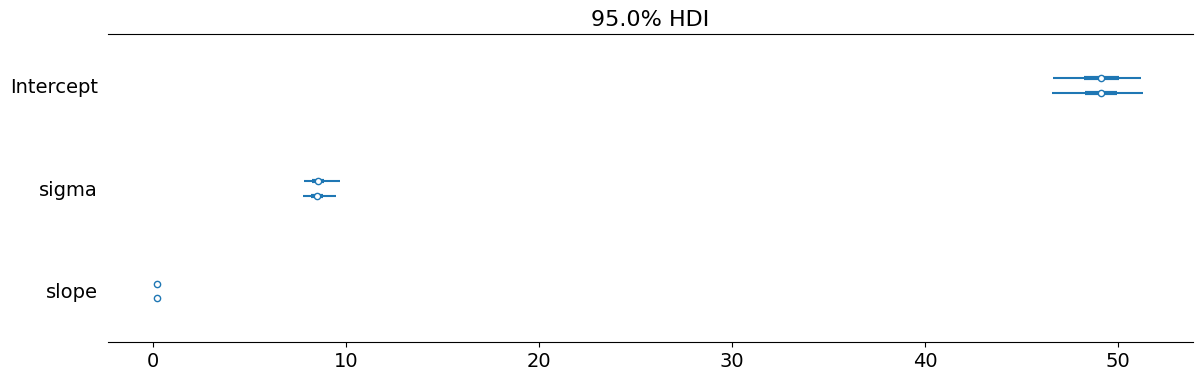

In [ ]:
with linear_all_data:
    pm.plot_forest(linear_trace_all_data, hdi_prob = 0.95, figsize = (14,4))
plt.show()

In [ ]:
import arviz as az

In [ ]:
try:
    import bambi as bmb
except ImportError:
    import sys
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

model = bmb.Model("y ~ x", xdata.join(ydata).rename(columns={
    'DATE': 'x',
    'TMAX': 'y'
}))
idata = model.fit(draws=3000)

Output()

Output()

In [ ]:
import xarray as xr

idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(xdata)

Text(0.5, 1.0, 'TMAX in Atlanta')

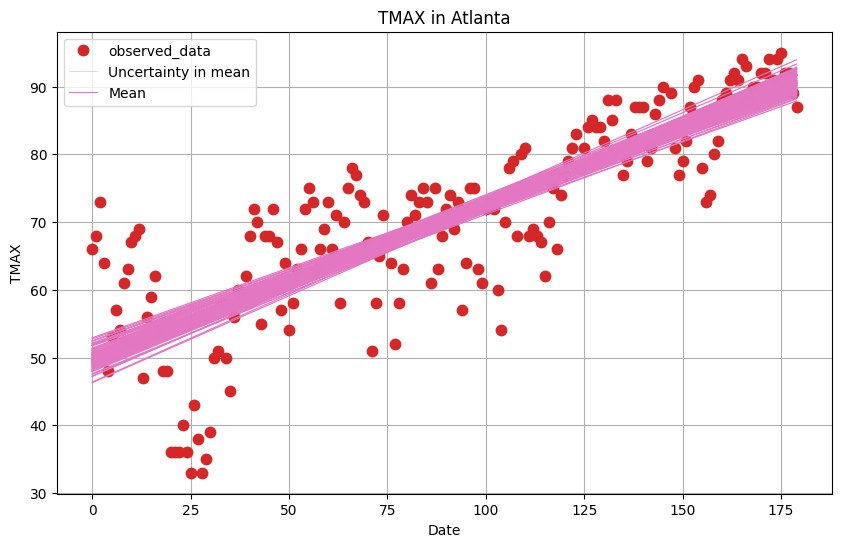

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax.set_xlabel('Date')
ax.set_ylabel('TMAX')
ax.set_title('TMAX in Atlanta')

In [ ]:
bayes_exp_intercept

/usr/local/lib/python3.10/dist-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


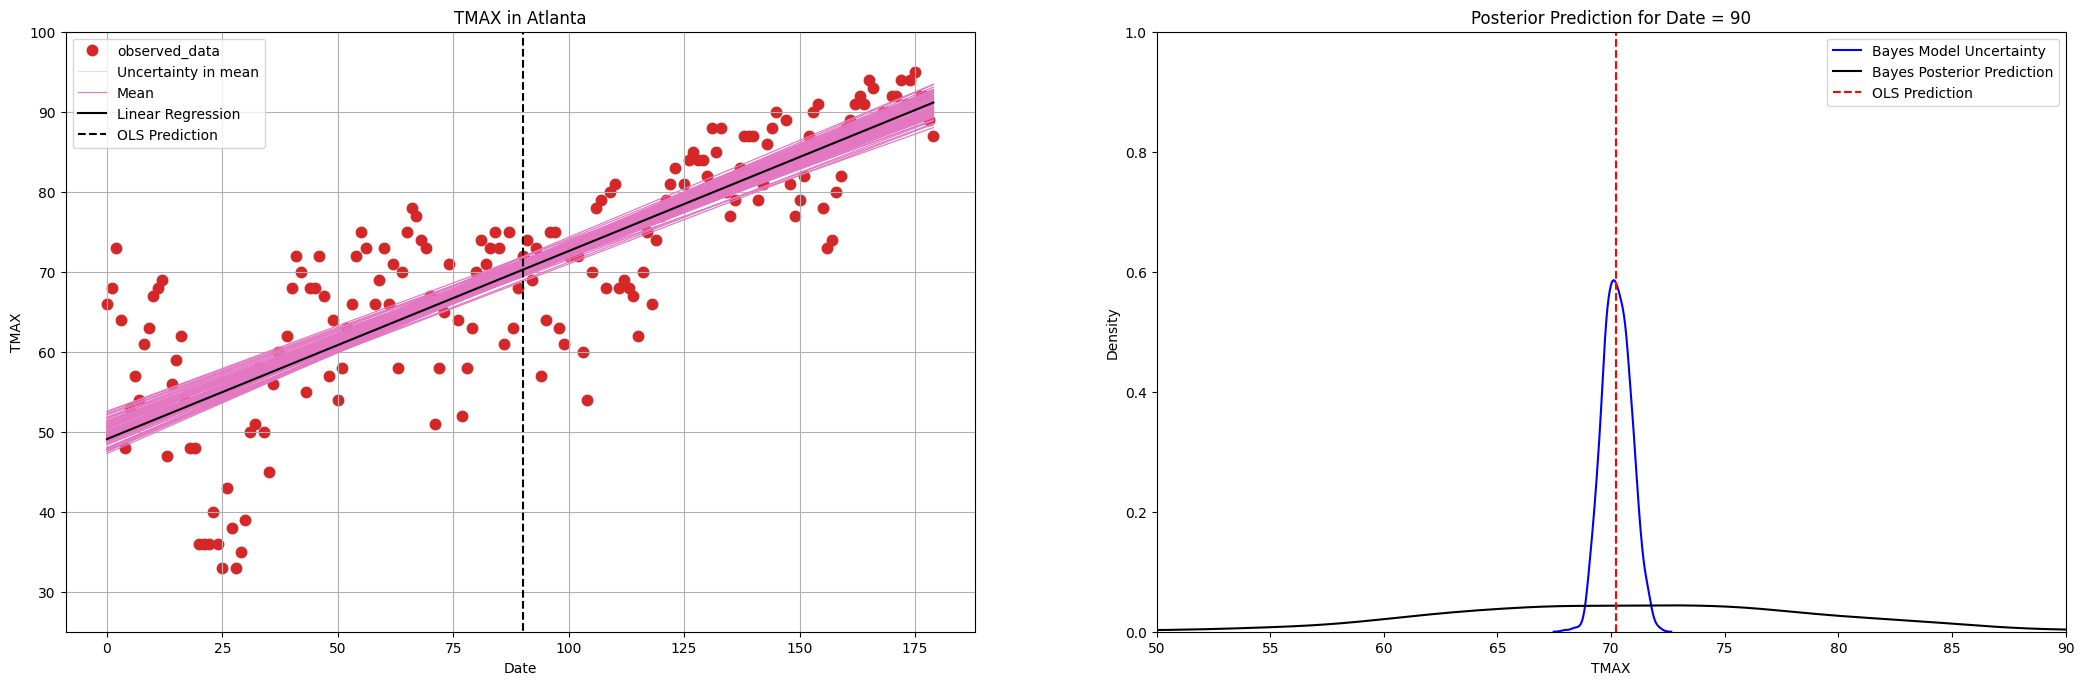

In [ ]:
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

lat = 90

plt.subplot(121)

az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax1, y_model="y_model", y_kwargs={'zorder': 1})
plt.plot(xdata, bayes_exp_slope * xdata + bayes_exp_intercept, color='black', label='Linear Regression', zorder=100)
plt.vlines(x = lat, ymin = 0, ymax = 100, label = 'OLS Prediction',colors = 'black', linestyles='--', zorder=100)

ax1.set_xlabel('Date')
ax1.set_ylabel('TMAX')
ax1.set_title('TMAX in Atlanta')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax1.set_ylim(25, 100)

plt.subplot(122)

nruns = linear_trace_all_data.posterior['slope'].shape[0]
slopes = linear_trace_all_data.posterior['slope'].values
intercepts = linear_trace_all_data.posterior['Intercept'].values
sigmas = linear_trace_all_data.posterior['sigma'].values

model_uncert = intercepts + slopes * lat
sns.kdeplot(model_uncert.flatten(), label = 'Bayes Model Uncertainty', color = 'blue')
bayes_prediction = intercepts + slopes * lat + np.random.normal(loc=0,scale=sigmas,size=[nruns,500])
sns.kdeplot(bayes_prediction.flatten(), label = 'Bayes Posterior Prediction', color = 'black')
plt.vlines(x = bayes_exp_intercept + bayes_exp_slope * lat, ymin = 0, ymax = 1, label = 'OLS Prediction',colors = 'red', linestyles='--')

plt.xlim(50, 90)
plt.ylim(0, 1)
plt.xlabel('TMAX')
plt.ylabel('Density');
plt.title('Posterior Prediction for Date = ' + str(lat));
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()